In [1]:
# Author: Ernesto Rodríguez
# github.com/ernestorodg

###############################################################################
## Analyse Bezerra's dataset for intrusion detection using Decision Trees
###############################################################################

In [2]:
import pandas as pd
import numpy as np
import sys

###############################################################################
## Define constants 
###############################################################################


# Random state for reproducibility
STATE = 0
np.random.seed(10)
# List of available attacks on the dataset


# Especific to the repository 
DATASET_DIRECTORY = r'../datasets/Dataset-bezerra-IoT-20200528T203526Z-001/Dataset-IoT/'
NETFLOW_DIRECTORY = r'NetFlow/'


# There are different csv files on the Dataset, with different types of data:

# Some meanings:
# MC: Media Center
# I: One hour of legitimate and malicious NetFlow data from profile.
# L: One hour of legitimate NetFlow data from profile.

MC = r'MC/'
ST = r'ST/'
SC = r'SC/'


# MC_I_FIRST: Has infected data by Hajime, Aidra and BashLite botnets 
MC_I_FIRST = r'MC_I1.csv'

# MC_I_SECOND: Has infected data from Mirai botnets
MC_I_SECOND = r'MC_I2.csv'

# MC_I_THIR: Has infected data from Mirai, Doflo, Tsunami and Wroba botnets
MC_I_THIRD = r'MC_I3.csv'

# MC_L: Has legitimate data, no infection
MC_L = r'MC_L.csv'


# Constants for ST
ST_I_FIRST = r'ST_I1.csv'
ST_I_SECOND = r'ST_I2.csv'
ST_I_THIRD = r'ST_I3.csv'
ST_L = r'ST_L.csv'

# Constants for SC
SC_I_FIRST = r'SC_I1.csv'
SC_I_SECOND = r'SC_I2.csv'
SC_I_THIRD = r'SC_I3.csv'
SC_L = r'SC_L.csv'


In [3]:
###############################################################################
## Load dataset
###############################################################################

# For MC data:
df_mc_I_first = pd.read_csv (DATASET_DIRECTORY + MC + NETFLOW_DIRECTORY + MC_I_FIRST)
df_mc_I_second = pd.read_csv (DATASET_DIRECTORY + MC + NETFLOW_DIRECTORY + MC_I_SECOND)
df_mc_I_third = pd.read_csv (DATASET_DIRECTORY + MC + NETFLOW_DIRECTORY + MC_I_THIRD)

# Add legitimate rows from MC_L
legitimate_frame_mc = pd.read_csv (DATASET_DIRECTORY + MC + NETFLOW_DIRECTORY + MC_L)

###################

# For ST data:
df_st_I_first = pd.read_csv (DATASET_DIRECTORY + ST + NETFLOW_DIRECTORY + ST_I_FIRST)
df_st_I_second = pd.read_csv (DATASET_DIRECTORY + ST + NETFLOW_DIRECTORY + ST_I_SECOND)
df_st_I_third = pd.read_csv (DATASET_DIRECTORY + ST + NETFLOW_DIRECTORY + ST_I_THIRD)

# Add legitimate rows from SC_L
legitimate_frame_st = pd.read_csv (DATASET_DIRECTORY + ST + NETFLOW_DIRECTORY + ST_L)


###################

# For SC data:
df_sc_I_first = pd.read_csv (DATASET_DIRECTORY + SC + NETFLOW_DIRECTORY + SC_I_FIRST)
df_sc_I_second = pd.read_csv (DATASET_DIRECTORY + SC + NETFLOW_DIRECTORY + SC_I_SECOND)
df_sc_I_third = pd.read_csv (DATASET_DIRECTORY + SC + NETFLOW_DIRECTORY + SC_I_THIRD)

# Add legitimate rows from MC_L
legitimate_frame_sc = pd.read_csv (DATASET_DIRECTORY + SC + NETFLOW_DIRECTORY + SC_L)

dataframes_list = [df_mc_I_first,
                df_mc_I_second,
                df_mc_I_third,
                legitimate_frame_mc,
                df_st_I_first,
                df_st_I_second,
                df_st_I_third,
                legitimate_frame_st,
                df_sc_I_first,
                df_sc_I_second,
                df_sc_I_third,
                legitimate_frame_sc]

# Joining the differents DataFrames
prev_df = pd.concat(dataframes_list)



In [4]:
###############################################################################
## Modify the DataFrame
###############################################################################


# Sample the dataset if necessary
df = prev_df.sample (frac = 1, replace = True, random_state = 0)

# We can see that this dataset has a temporal description.
# So it is not a good idea to randomly remove rows

# In this case we drop the index column, since pandas library creates an index
# automatically. 
df = df.drop(df.columns[0], axis=1)

# Also drop columns that has no significant data
df = df.drop(df.columns[14:], axis=1)

# Initial and end time is not a good feature for svm model
df = df.drop(['ts', 'te'], axis=1)

# Trying another drops to see relation between features and results
df = df.drop(['fwd', 'stos'], axis=1)
# 'sp', 'dp', 'sa',  'da',  

# Counting number of null data
nanColumns = [i for i in df.columns if df [i].isnull ().any ()]

# Remove NaN and inf values
df.replace ('Infinity', np.nan, inplace = True) ## Or other text values
df.replace (np.inf, np.nan, inplace = True) ## Remove infinity
df.replace (np.nan, 0, inplace = True)


# if (df.Label.value_counts()[1] < df.Label.value_counts()[0]):
#     remove_n =  df.Label.value_counts()[0] - df.Label.value_counts()[1]  # Number of rows to be removed   
#     print(remove_n)
#     df_to_be_dropped = df[df.Label == 0]
#     drop_indices = np.random.choice(df_to_be_dropped.index, remove_n, replace=False)
#     df = df.drop(drop_indices)
# else: 
#     remove_n =  df.Label.value_counts()[1] - df.Label.value_counts()[0]  # Number of rows to be removed   
#     print(remove_n)
#     df_to_be_dropped = df[df.Label == 1]
#     drop_indices = np.random.choice(df_to_be_dropped.index, remove_n, replace=False)
#     df = df.drop(drop_indices)


In [27]:
###############################################################################
## Slice the dataframe (usually the last column is the target)
###############################################################################

X = pd.DataFrame(df.iloc [:, 1:])

# Selecting other columns
# X = pd.concat([X, df.iloc[:, 2]], axis=1)

y = df.iloc [:, 0]
print('Number of non-attacks: ', y.value_counts()[0])
print('Number of attacks: ', y.value_counts()[1])

# See Output, only available on jupyter-notebooks
# X

Number of non-attacks:  7998
Number of attacks:  1716408


In [28]:
###############################################################################
## Create artificial non-attacks samples using Random Oversampling
###############################################################################

from imblearn.over_sampling import RandomOverSampler # doctest: +NORMALIZE_WHITESPACE

ros = RandomOverSampler(random_state=42)

X, y = ros.fit_resample(X, y)

print('Number of non-attacks: ', y.value_counts()[0])
print('Number of attacks: ', y.value_counts()[1])

Number of non-attacks:  1716408
Number of attacks:  1716408


In [29]:
###############################################################################
## Split dataset into train and test sets if not using cross validation
###############################################################################
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 1/5,
                                                     random_state = STATE)


print ('\nSplitting dataset (validation/train):', 1/5)
X_train_val, X_val, y_train_val, y_val = train_test_split (
                                             X_train,
                                             y_train,
                                             test_size = 1/5,
                                             random_state = STATE)


X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_train_val = pd.DataFrame(X_train_val)
X_val = pd.DataFrame(X_val)



Splitting dataset (validation/train): 0.2


In [31]:
####################################################################
# Treat categorical data on train set
####################################################################
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder


cat_cols = X_train.columns[X_train.dtypes == 'O'] # Returns array with the columns that has Object types elements

categories = [
    X_train[column].unique() for column in X_train[cat_cols]]

for cat in categories:
    cat[cat == None] = 'missing'  # noqa

# Replacing missing values
categorical_imputer = SimpleImputer(missing_values=None, 
                                    strategy='constant', 
                                    fill_value='missing')

X_train[cat_cols] = categorical_imputer.fit_transform(X_train[cat_cols])

# Encoding the categorical data
categorical_encoder = OrdinalEncoder(categories = categories)
categorical_encoder.fit(X_train[cat_cols])
X_train[cat_cols] = categorical_encoder.transform(X_train[cat_cols])

categorical_encoder.fit(X_train_val[cat_cols])
X_train_val[cat_cols] = categorical_encoder.transform(X_train_val[cat_cols])

In [32]:
####################################################################
# Treat categorical data on test set
####################################################################
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder


cat_cols = X_test.columns[X_test.dtypes == 'O'] # Returns array with the columns that has Object types elements

categories = [
    X_test[column].unique() for column in X_test[cat_cols]]

for cat in categories:
    cat[cat == None] = 'missing'  # noqa

# Replacing missing values
categorical_imputer = SimpleImputer(missing_values=None, 
                                    strategy='constant', 
                                    fill_value='missing')

X_test[cat_cols] = categorical_imputer.fit_transform(X_test[cat_cols])

# Encoding the categorical data
categorical_encoder = OrdinalEncoder(categories = categories)
categorical_encoder.fit(X_test[cat_cols])
X_test[cat_cols] = categorical_encoder.transform(X_test[cat_cols])


In [33]:
####################################################################
# Treat categorical data on val set
####################################################################
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder


cat_cols = X_val.columns[X_val.dtypes == 'O'] # Returns array with the columns that has Object types elements

categories = [
    X_val[column].unique() for column in X_val[cat_cols]]

for cat in categories:
    cat[cat == None] = 'missing'  # noqa

# Replacing missing values
categorical_imputer = SimpleImputer(missing_values=None, 
                                    strategy='constant', 
                                    fill_value='missing')

X_val[cat_cols] = categorical_imputer.fit_transform(X_val[cat_cols])

# Encoding the categorical data
categorical_encoder = OrdinalEncoder(categories = categories)
categorical_encoder.fit(X_val[cat_cols])
X_val[cat_cols] = categorical_encoder.transform(X_val[cat_cols])


In [34]:
####################################################################
# Treat numerical data 
####################################################################
from sklearn.preprocessing import StandardScaler


num_cols = X_train.columns[(X_train.dtypes == 'float64') | (X_train.dtypes == 'int64')] # Returns array with the columns that has float types elements

# Scaling numerical values

numerical_scaler = StandardScaler()
numerical_scaler.fit(X_train)
X_train = numerical_scaler.transform(X_train)

X_test = numerical_scaler.transform(X_test)

X_val = numerical_scaler.transform(X_val)

# X_train

In [35]:
###############################################################################
## Training the model without cross-validation (simpler than the training above)
###############################################################################

# scikit-learn uses an optimised version of the CART algorithm;
# however, scikit-learn implementation does not support categorical variables for now

from sklearn import tree
import time

# Assign the model to be used
clf = tree.DecisionTreeClassifier()

In [37]:
###############################################################################
## Create learning model (Decision Tree) and tune hyperparameters
###############################################################################
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

### -1 indices -> train
### 0  indices -> validation
test_fold = np.repeat ([-1, 0], [X_train_val.shape [0], X_val.shape [0]])
myPreSplit = PredefinedSplit (test_fold)
#myPreSplit.get_n_splits ()
#myPreSplit.split ()
#for train_index, test_index in myPreSplit.split ():
#    print ("TRAIN:", train_index, "TEST:", test_index)


parameters = {'criterion' : ['gini', 'entropy'],
              'splitter' : ['best', 'random'],
              'max_depth' : [1, 10, 100, 1000, 10000, 100000, 1000000, None],
              'min_samples_split' : [2, 3, 4]}
clf = DecisionTreeClassifier ()
model = GridSearchCV (estimator = clf,
                      param_grid = parameters,
                      scoring = 'f1_weighted',
                      cv = myPreSplit,
                      verbose = 1)

model.fit (np.concatenate ((X_train_val, X_val), axis = 0),
           np.concatenate ((y_train_val, y_val), axis = 0))

print (model.best_params_)



Fitting 1 folds for each of 96 candidates, totalling 96 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed: 10.9min finished


{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2, 'splitter': 'best'}


In [48]:
# ###############################################################################
# ## Obtain metrics from the validation model 
# ###############################################################################

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)

# New Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))

#Logistic Regression (Grid Search) Confusion matrix
confusion_matrix(y_test,y_pred)

Accuracy Score : 0.8520079701236883
Precision Score : 0.7771851484329777
Recall Score : 0.9865753025222336
F1 Score : 0.869451032894855


array([[246612,  97002],
       [  4604, 338346]])

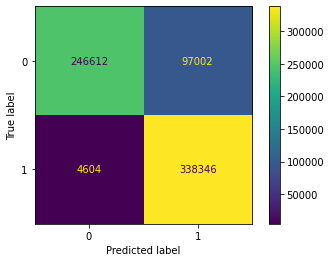

In [49]:
###############################################################################
## Plotting confusion matrix
###############################################################################
from sklearn.metrics import plot_confusion_matrix
from matplotlib import pyplot as plt

plot_confusion_matrix(model, X_test, y_test)  # doctest: +SKIP
plt.savefig("decision_tree_confusion_matrix_with_tuning.png", format="png")
plt.show()  # doctest: +SKIP
# td  sp  dp  pr  flg  ipkt ibyt

In [50]:
###############################################################################
## Train the model with other parameters
###############################################################################

# Measure time of this training
start_time = time.time()

# Assign the model to be used with adjusted parameters
clf = tree.DecisionTreeClassifier(max_depth = 1000000)

# Training the model
model = clf.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 14.528177261352539 seconds ---


In [51]:
###############################################################################
## Obtain metrics from the above model 
###############################################################################
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix


# Predicting from the test slice
y_pred = model.predict(X_test)

# Precision == TP / (TP + FP)
print('Precision Score: ', precision_score(y_test, y_pred))

# Recall == TP / (TP + FN)
print('Recall Score: ', recall_score(y_test, y_pred))

# Accuracy 
train_score = model.score(X_test, y_test)
print('Accuracy: ', train_score)

# f1 
f_one_score = f1_score(y_test, y_pred)
print('F1 Score: ', f_one_score)

# Multilabel Confusion Matrix: 
# [tn fp]
# [fn tp]
print(multilabel_confusion_matrix(y_test, y_pred, labels=[0, 1]))

Precision Score:  0.978988069061231
Recall Score:  0.999632599504301
Accuracy:  0.9890993410665284
F1 Score:  0.9892026338417502
[[[342824    126]
  [  7358 336256]]

 [[336256   7358]
  [   126 342824]]]


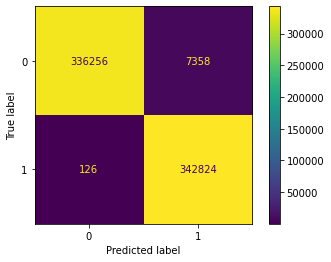

In [52]:
###############################################################################
## Plotting confusion matrix
###############################################################################

plot_confusion_matrix(model, X_test, y_test)  # doctest: +SKIP
plt.savefig("decision_tree_confusion_matrix_without_tuning.png", format="png")
plt.show()  # doctest: +SKIP
# td  sp  dp  pr  flg  ipkt ibyt